In [32]:
import cv2 as cv
import mediapipe as mp
import pandas as pd
import sys
from collections import deque

In [33]:
sys.path.insert(0, '../')

In [34]:
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(static_image_mode = True,
    max_num_hands = 2,
    min_detection_confidence = 0.7,
    min_tracking_confidence = 0.5
)

In [35]:
train_hands = pd.read_csv(filepath_or_buffer='_classes_train.csv',sep = ',')
test_hands = pd.read_csv(filepath_or_buffer='_classes_test.csv',sep = ',')
valid_hands = pd.read_csv(filepath_or_buffer='_classes_valid.csv',sep = ',')
train_hands = train_hands.reset_index()
test_hands = test_hands.reset_index()
valid_hands = valid_hands.reset_index()


In [36]:
from utils import landmark

def obtain_landmarks(folder,list_hands):
    df_result = pd.DataFrame()
    for index, row in list_hands.iterrows():
        image = cv.imread('./{}/{}'.format(folder,row['filename']))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True
        if results.multi_hand_landmarks is not None:
            for hand_landmarks,handness in zip(results.multi_hand_landmarks,
                                                results.multi_handedness):
                # Calcular Landmarks
                landmark_list = landmark.calc_landmark_list(image, hand_landmarks)
                #Convertir a cordenadas relativas / normalizada
                pre_processed_landmark_list = landmark.pre_process_landmark(
                    landmark_list)
                data_result =  list(row[2:]) + list(pre_processed_landmark_list)
                df_result = pd.concat([df_result, pd.DataFrame([data_result])], ignore_index=True)
               

    return df_result, pre_processed_landmark_list



In [37]:
training_df,pre_process_landmark_train = obtain_landmarks('train_data', train_hands)
test_df, pre_process_landmark_test = obtain_landmarks('test_data', test_hands)
valid_df, pre_process_landmark_valid = obtain_landmarks('valid_data', valid_hands)

In [38]:
def assign_names(df,list):
    column_names = (train_hands.columns[2:]).tolist()
    landmark_name = []
    for row,landmarks in enumerate(list):
        landmark_name.append('landmark_{}'.format(row))
    dataframe_columns = column_names + landmark_name
    df.columns = dataframe_columns

In [39]:
assign_names(training_df, pre_process_landmark_train)
assign_names(test_df, pre_process_landmark_test)
assign_names(valid_df, pre_process_landmark_valid)


In [40]:
training_df

,A,B,C,D,E,EYE,F,G,H,I,...,landmark_32,landmark_33,landmark_34,landmark_35,landmark_36,landmark_37,landmark_38,landmark_39,landmark_40,landmark_41
0,0,0,0,0,0,0,0,0,0,0,...,0.103015,-0.288945,0.238693,-0.371859,0.329146,-0.437186,0.258794,-0.321608,0.158291,-0.246231
1,0,1,0,0,0,0,0,0,0,0,...,-0.092937,-0.959108,0.081784,-0.382900,0.063197,-0.557621,0.059480,-0.680297,0.052045,-0.795539
2,0,0,0,0,0,0,0,0,0,0,...,0.597222,-0.138889,0.638889,-0.069444,0.750000,-0.055556,0.687500,-0.034722,0.604167,-0.027778
3,0,0,0,0,0,0,0,0,0,0,...,-0.973913,-0.291304,-0.352174,-0.456522,-0.621739,-0.482609,-0.791304,-0.413043,-0.900000,-0.339130
4,0,0,0,0,0,0,0,0,0,0,...,0.611465,0.025478,0.541401,0.019108,0.662420,0.076433,0.617834,0.095541,0.560510,0.089172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,0,0,1,0,0,0,0,0,0,0,...,-0.897436,-0.579487,-0.235897,-0.502564,-0.415385,-0.641026,-0.574359,-0.666667,-0.712821,-0.646154
768,0,0,0,0,0,0,0,0,0,0,...,0.282051,0.758974,0.302564,0.343590,0.353846,0.687179,0.246154,0.748718,0.189744,0.682051
769,0,0,0,0,0,0,0,0,0,0,...,-0.591760,-0.247191,-0.325843,-0.584270,-0.591760,-0.749064,-0.790262,-0.861423,-0.936330,-0.940075
770,0,0,0,0,0,1,0,0,0,0,...,0.238443,-0.333333,0.389294,-0.284672,0.474453,-0.384428,0.401460,-0.347932,0.321168,-0.309002


In [41]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [42]:
NUM_CLASSES = 27
MODEL_PATH_SAVE = './HandClassifier/keypoint_classifier.hdf5'
TFLITE_PATH_SAVE = './HandClassifier/keypoint_classifier.tflite'

In [43]:
#Construcción del data entrenamiento X y Y
y_train = pd.DataFrame(training_df.iloc[:, :27])
X_train = pd.DataFrame(training_df.iloc[:, 27:])
y_test = pd.DataFrame(test_df.iloc[:, :27])
X_test = pd.DataFrame(test_df.iloc[:, 27:])
y_valid = pd.DataFrame(valid_df.iloc[:, :27])
X_valid = pd.DataFrame(valid_df.iloc[:, 27:])

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    tf.keras.layers.Dense(280, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 280)               12040     
                                                                 
 dropout_1 (Dropout)         (None, 280)               0         
                                                                 
 dense_4 (Dense)             (None, 140)               39340     
                                                                 
 dense_5 (Dense)             (None, 27)                3807      
                                                                 
Total params: 55,187
Trainable params: 55,187
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH_SAVE, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [47]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=tf.metrics.CategoricalAccuracy()
)

In [48]:
history = model.fit(
    X_train,
    y_train,
    epochs=70,
    batch_size=256,
    validation_data=(X_valid, y_valid),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/70


1/4 [======>.......................] - ETA: 1s - loss: 3.3162 - categorical_accuracy: 0.0352
Epoch 1: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 1s 64ms/step - loss: 3.2576 - categorical_accuracy: 0.0816 - val_loss: 3.1053 - val_categorical_accuracy: 0.1773
Epoch 2/70
1/4 [======>.......................] - ETA: 0s - loss: 3.1180 - categorical_accuracy: 0.1953
Epoch 2: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 0s 21ms/step - loss: 3.0883 - categorical_accuracy: 0.1762 - val_loss: 2.9716 - val_categorical_accuracy: 0.1909
Epoch 3/70
1/4 [======>.......................] - ETA: 0s - loss: 2.9694 - categorical_accuracy: 0.1719
Epoch 3: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 0s 19ms/step - loss: 2.9616 - categorical_accuracy: 0.1826 - val_loss: 2.8624 - val_categorical_accuracy: 0.2136
Epoch 4/70
1/4 [======>...................

In [49]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 25ms/step - loss: 1.0406 - categorical_accuracy: 0.6364


In [50]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

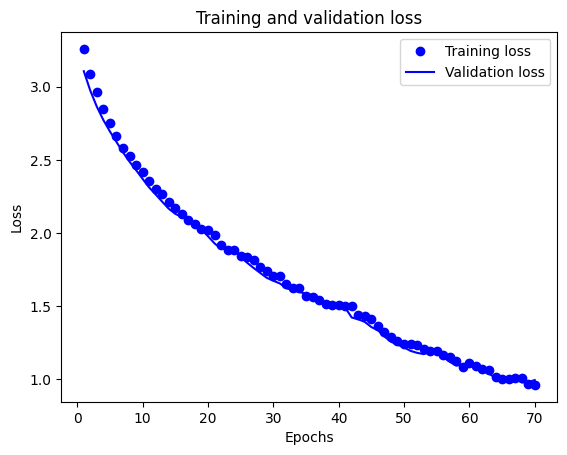

In [51]:

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


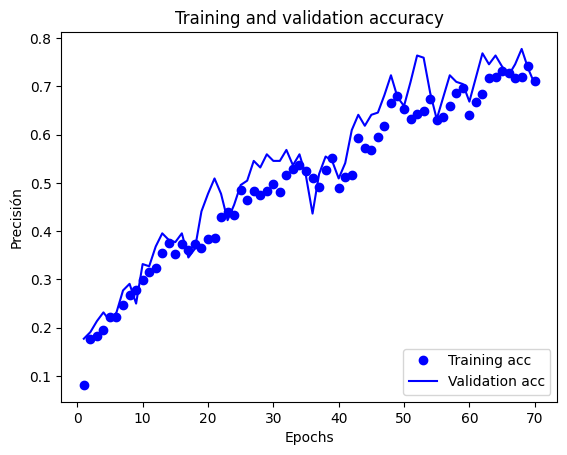

In [52]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend(loc='lower right')

plt.show()


In [53]:
# Loading the saved model
model = tf.keras.models.load_model(MODEL_PATH_SAVE)

In [54]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    
    class_report_df['avg / total'] = avg

    return class_report_df.T

4/4 [==============================] - 0s 0s/step


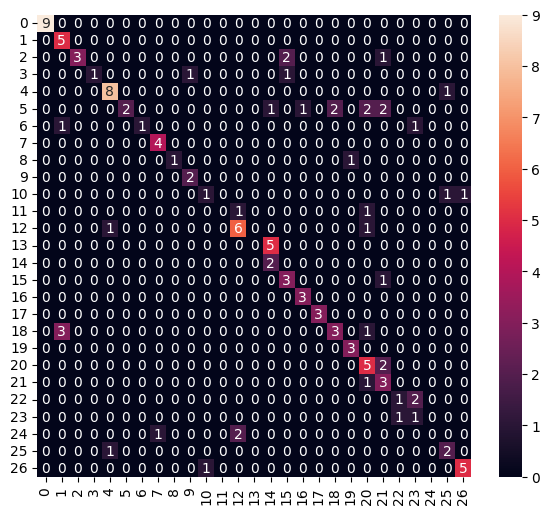

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.56      1.00      0.71         5
           2       1.00      0.50      0.67         6
           3       1.00      0.33      0.50         3
           4       0.80      0.89      0.84         9
           5       1.00      0.20      0.33        10
           6       1.00      0.33      0.50         3
           7       0.80      1.00      0.89         4
           8       1.00      0.50      0.67         2
           9       0.67      1.00      0.80         2
          10       0.50      0.33      0.40         3
          11       0.00      0.00      0.00         2
          12       0.67      0.75      0.71         8
          13       0.00      0.00      0.00         5
          14       0.25      1.00      0.40         2
          15       0.50      0.75      0.60         4
          16       0.75      1.00      0.86         3
     

c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

y_test_true = np.array(y_test)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test_true, axis=1)
print_confusion_matrix(y_true, y_pred)

In [56]:
# Guardar como modelo dedicado para interferencias
model.save(MODEL_PATH_SAVE, include_optimizer=False)

In [57]:
#Convertir a modelo TF-LITE

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(TFLITE_PATH_SAVE, 'wb').write(tflite_quantized_model)



INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmpdxwejbov\assets


INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmpdxwejbov\assets


58824

## Prueba de Interferencia

In [58]:
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH_SAVE)
interpreter.allocate_tensors()

In [59]:
# Obtener I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [60]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test.iloc[0]], dtype='float32'))

In [61]:
%%time
# Implementación de la interferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8979874e-05 3.4007107e-06 3.0353220e-05 1.7653972e-05 4.4743789e-05
 2.8300908e-01 1.1233134e-05 1.1618641e-02 5.9268004e-03 1.3532655e-06
 5.7368348e-03 1.5523588e-05 1.2345957e-04 1.0576832e-01 4.9223665e-02
 4.6935111e-05 4.8212108e-01 6.0778988e-05 5.0570175e-06 4.2884566e-02
 8.1826347e-06 2.9008466e-05 8.7662210e-04 1.6449554e-05 8.2391240e-03
 3.6687246e-03 4.9346685e-04]
16
